## Association subtypes language task

In [1]:
import seaborn as sns
import os
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
import scipy.io #read .mat files
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR,LinearSVR
from sklearn import preprocessing, linear_model
from sklearn.ensemble import RandomForestRegressor , ExtraTreesRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle

In [93]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [6]:
#  Set path
#path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_LANGUAGE_03-Oct-2017/';
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/';
path_subtype = os.path.join(path_root,'subtype_7_spm_LANGUAGE_18-Oct-2017/');
path_association =  os.path.join(path_subtype,'associations/');
path_networks =  os.path.join(path_subtype,'networks/');
nb_sbt = 7

In [7]:
#custom function for key sorting element
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [8]:
# List phenotypes
list_pheno  = [f for f in os.listdir(path_association)]
list_pheno.sort(key=natural_keys)
list_pheno

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7',
 'Cluster_8',
 'Cluster_9',
 'Cluster_10']

In [9]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial 

['story']

In [10]:
list_subtype = ['sub{}'.format(ii) for ii in range(1,nb_sbt+1)]
list_subtype

['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7']

In [11]:
# Create R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
        if ix == 0:
            pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_subtype,'{}_r2.csv'.format(trial_name)))

In [12]:
pheno_r2_final

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
sub1,0.022735,0.027419,0.026915,0.028526,0.023553,0.027369,0.026543,0.031727,0.027224,0.038666
sub2,0.027240,0.028419,0.025508,0.027223,0.025119,0.028267,0.026174,0.025576,0.025338,0.028402
sub3,0.021469,0.025408,0.025630,0.027257,0.022023,0.024985,0.024838,0.029508,0.025212,0.037171
sub4,0.026676,0.017956,0.018005,0.018573,0.017541,0.018858,0.017019,0.018677,0.034945,0.089938
sub5,0.023339,0.027675,0.027447,0.028848,0.023792,0.026606,0.027097,0.029806,0.025509,0.032361
sub6,0.021616,0.026729,0.026047,0.027305,0.023652,0.026703,0.027392,0.036615,0.031645,0.037010
sub7,0.027852,0.029202,0.028166,0.031084,0.027713,0.030660,0.027493,0.040042,0.044201,0.095245


### On first run in new machine do
Step 1 — Installing System Dependencies for devtools

`sudo apt-get install build-essential libcurl4-gnutls-dev libxml2-dev libssl-dev libcairo2-dev r-cran-stringr`

Step 2 — Installing the Devtools Package

```sudo -i R
install.packages('devtools')
devtools::install_github("hadley/svglite")
devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)```

In [13]:
%%R
library(ggradar)
library(svglite)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

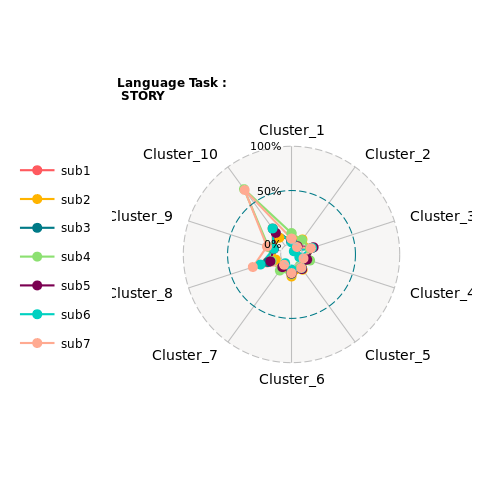

In [14]:
%%R -i path_subtype,path_association,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_subtype,ii,"_r2_SVR.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = -0.01,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Language Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_subtype,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

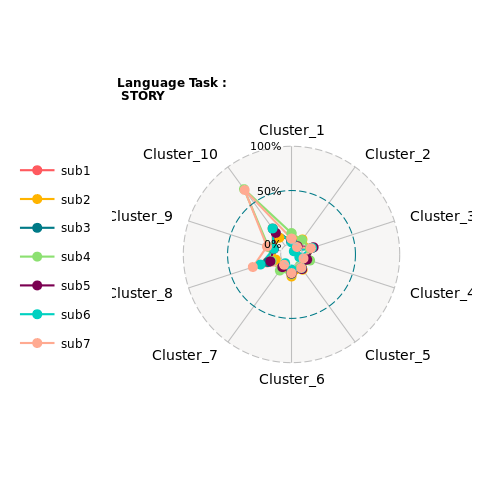

In [15]:
%%R -i path_subtype,path_association,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_subtype,ii,"_r2_SVR.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = -0.01,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Language Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_subtype,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

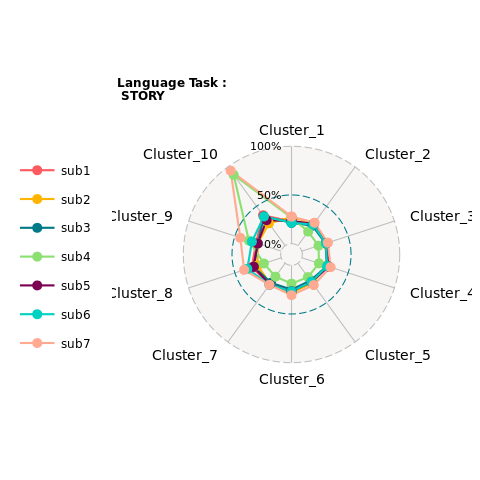

In [16]:
%%R -i path_subtype,path_association,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_subtype,ii,"_r2.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = 0,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Language Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_subtype,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

In [17]:
# # plot association wieght and phenotypes
# for trial_name in list_trial :
#     # build R2 table for radar plot
#     for ix, pheno_name in enumerate(list_pheno):
#         mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
#         %octave_push mat_file
#         %octave mat_load = load(mat_file);
#         %octave_pull mat_load
#         model_y =mat_load['model_raw']['y']
#         model_x = mat_load['model_raw']['x']
#         model_labels_x = mat_load['model_raw']['labels_x']
#         model_labels_y = mat_load['model_raw']['labels_y']
#         concat = [np.concatenate([model_y[x], model_x[x]]) for x in range(np.shape(model_y)[0])]
#         model_df = pd.DataFrame(concat)
#         model_df.index = model_labels_x
#         colnames = np.concatenate([list_subtype,model_labels_y])
#         model_df.columns = colnames
#         model_df.to_csv(os.path.join(path_subtype,'{}_pheno_subtype.csv'.format(trial_name)))
        
#         # plot association maps
#         #for subtype in list_subtype:
#         #    fig = plt.figure(figsize=(9,16))
#         #    ax1 = fig.add_subplot(511)
#         #    ax1 = sns.regplot(x=pheno_name, y=subtype, data=model_df,color="#BCB6FF");
#         #    ax1.set_ylabel('{}_{}'.format(trial_name,subtype))
#         #    ax1.set_xlabel(pheno_name)

## Random forest and linear regressionn association 

In [18]:
def RandomForest_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : Random forest regression
    rfr = RandomForestRegressor(n_estimators=1000,oob_score=True,n_jobs=-1)
    skf = KFold(n_splits)
    feimp = np.zeros((skf.n_splits,X.shape[1]))
    scores = np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfr.fit(x_train, y_train)
        y_pred = rfr.predict(x_test)
        
        rsq = r2_score(y_test, y_pred)
        scores[c,:] = rsq
        
        feimp[c,:] = rfr.feature_importances_[:]
        
        std[c,:] = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
        #     plt.figure()
        #     plt.scatter(y_test, y_test, edgecolor='k',
        #             c="navy", s=s, marker="s", alpha=a, label="Test Data")
        
        #     plt.scatter(y_train, pred, edgecolor='k',
        #             c="c", s=s, marker="^", alpha=a,
        #             label="Prediction -- RF score=%.2f" % rsq)
        #     plt.title("Prediction on subset number {}".format(c))
        #     plt.legend()
        #     plt.show()
    print('Mean R-Squared score: %.3f' % scores.mean()) 
    return x_test, y_test,feimp, scores,std

In [19]:
def SVR_apply(X, y,n_splits=3,kern='linear',flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : SVR
    clf = SVR(kernel=kern)
    # grid search cv
    #clf = GridSearchCV(clf, cv=10,param_grid={"C": np.logspace(-2, 2, 10),"gamma": np.logspace(-2, 2, 10)})
    clf = GridSearchCV(clf, cv=5,param_grid={"C": np.logspace(-2, 3, 10),
                                             "gamma": np.logspace(-2, 2, 10)},n_jobs=-1)
    #clf = GridSearchCV(clf, cv=5,param_grid={"C": np.logspace(-2, 3, 5),'degree':[3,4,5]},n_jobs=6)
    
    
    skf = KFold(n_splits)
    scores = np.zeros((skf.n_splits,1))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        rsq = r2_score(y_test, y_pred)
        scores[c,:] = rsq
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            #fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            #plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            #fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            #plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
    print('Mean R-Squared score: %.3f' % scores.mean()) 
    return x_test, y_test,scores

In [20]:
def Linear_SVR_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    skf = KFold(n_splits)
    
    # apply machine learning :  LinearSVR
    clf = LinearSVR(random_state=0)
    
    Coeff = np.zeros((skf.n_splits,X.shape[1]))
    SquaredError = np.zeros((skf.n_splits,1))
    Rsquared =  np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
    
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        
        Coeff[c,:] = clf.coef_[:]
        SquaredError[c,:] = mean_squared_error(y_test, y_pred)
        Rsquared[c,:] = r2_score(y_test,y_pred)
        std[c,:] = np.std([coefi for coefi in clf.coef_],axis=0)
        
        # Plot outputs
        if flag_plot :
            
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            #fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            #plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            #fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            #plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % Rsquared[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
    print('Mean R-Squared score: %.3f' % Rsquared.mean()) 
    return Coeff,std, SquaredError,Rsquared

In [21]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30,40,50,100],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,6,8,10,12,14],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [22]:
def RFR(X_train, X_test, y_train, y_test, best_params):
    from sklearn.ensemble import RandomForestRegressor
    rfr = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    rfr.fit(X_train,y_train)
    
    y_pred = rfr.predict(X_test)
    
    rsq = r2_score(y_test, y_pred)
    feimp = rfr.feature_importances_[:]
    std_feimp = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
        
    print ("R2 score: %.3f" % rsq)
    return y_pred,rsq,feimp,std_feimp

In [23]:
def RandomForestOptim_apply(X, y,n_splits=3,flag_plot=True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    feimp:   mean feature importance
    scores: Mean R-squared
    std:    standar deviantion of R-squared
    """
    # apply machine learning : Random forest regression
    rfr = RandomForestRegressor(n_estimators=4000,oob_score=True,n_jobs=-1)
    skf = KFold(n_splits)
    feimp_c = np.zeros((skf.n_splits,X.shape[1]))
    scores_c = np.zeros((skf.n_splits,1))
    std_c =  np.zeros((skf.n_splits,X.shape[1]))
    
#     #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Grid search
        best_score, best_params = Grid_Search_CV_RFR(x_train, y_train)
        #Best params
        y_pred,rsq,feimp,std_feimp = RFR(x_train, x_test, y_train, y_test, best_params)
        print ("Best Score:%.03f" % best_score)
        print ("Best params:%s" % best_params)
        #stack results
        feimp_c[c,:] = feimp
        scores_c[c,:] = rsq
        std_c[c,:] = std_feimp
        
        if flag_plot :
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7

            fit_a = np.polyfit(x_test.reshape(-1), y_test, deg=1)
            plt.plot(x_test.reshape(-1), fit_a[0] * x_test.reshape(-1) + fit_a[1], color='navy',alpha=a)

            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")

            fit_b = np.polyfit(x_test.reshape(-1), y_pred, deg=1)
            plt.plot(x_test.reshape(-1), fit_b[0] * x_test.reshape(-1) + fit_b[1], color='c',alpha=a)

            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,label="Predicted data -- RSquared=%.2f" % scores[c,:] )
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
            
            
    print('Mean R-Squared score: %.3f' % scores_c.mean()) 
    return x_test, y_test,feimp_c, scores_c,std_c

In [24]:
def LinearRegression_apply(X, y,n_splits=3,flag_plot = True):
    """
    X: predictor
    y: variable to be predicted
    n_splits: number of split data
    
    returns:
    Coeff:   Mean Estimated coefficients for the linear regression problem
    SquaredError: Mean Squared Error
    Rsquared:     Mean coefficient of determination
    """
    # apply machine learning : Linear Regression
    regr = linear_model.LinearRegression()
    skf = KFold(n_splits)
    Coeff = np.zeros((skf.n_splits,X.shape[1]))
    SquaredError = np.zeros((skf.n_splits,1))
    Rsquared =  np.zeros((skf.n_splits,1))
    std =  np.zeros((skf.n_splits,X.shape[1]))
    feimp = np.zeros((skf.n_splits,X.shape[1]))
    
    #scale Y
#     scl = StandardScaler()
#     y = scl.fit_transform(y.reshape(-1, 1))
#     minmiax = MinMaxScaler(feature_range=(-1, 1))
#     y = minmiax.fit_transform(y)[:,0]
#     #scale x
#     scl = StandardScaler()
#     X = scl.fit_transform(X)
#     X, y = shuffle(X, y, random_state=0)
    
    for c, (train_index, test_index) in enumerate(skf.split(X)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        regr.fit(x_train, y_train)
        y_pred = regr.predict(x_test)
        
        # fit an Extra Trees model to the data
        forest = ExtraTreesRegressor(n_estimators=400,
                                     random_state=0)
        forest.fit(x_train, y_train)
        
        Coeff[c,:] = regr.coef_[:]
        SquaredError[c,:] = mean_squared_error(y_test, y_pred)
        Rsquared[c,:] = r2_score(y_test,y_pred)
        std[c,:] = np.std([coefi for coefi in forest.feature_importances_],axis=0)
        feimp[c,:] = forest.feature_importances_
        
        if flag_plot:
            # Plot outputs
            plt.figure(figsize=(15,4))
            s = 100
            a = 0.7
            plt.scatter(x_test, y_test,  edgecolor='k',
                c="navy", s=s, marker="s", alpha=a, label="Test Data")
            plt.scatter(x_test, y_pred, edgecolor='k',
                c="c", s=s, marker="^", alpha=a,
                label="Predicted data -- RSquared=%.2f" % Rsquared[c,:])
            plt.title("Prediction on subset number {}".format(c))
            plt.legend()
            plt.show()
        
    print('Mean R-Squared score: %.3f' % Rsquared.mean())    
    return Coeff,std, SquaredError,Rsquared,feimp

In [25]:
for trial_name in list_trial :
    # collect all clusters
    allClusters = []
    nameClusters = []
    for ix, pheno_name in enumerate(list_pheno):
        #from IPython.core.debugger import Tracer; Tracer()() 
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        model_x_norm = mat_load['model_norm']['x']
        model_labels_y_norm = mat_load['model_norm']['labels_y']
        myCluster = np.array(model_x_norm[:,1])
        myClusterName= model_labels_y_norm[1]
        allClusters.append(myCluster)
        nameClusters.append(myClusterName)
        
    # create clusters
    allClusters = np.transpose(allClusters)
    model_y_norm =mat_load['model_norm']['y']
    model_labels_x_norm = mat_load['model_norm']['labels_x']
    
    # concatenate clusters with subtype weight
    concat = [np.concatenate([model_y_norm[x], allClusters[x]]) for x in range(np.shape(model_y_norm)[0])]
    all_clusters_df = pd.DataFrame(concat)
    all_clusters_df.index = model_labels_x_norm
    colnames = np.concatenate([list_subtype,nameClusters])
    all_clusters_df.columns = colnames
    
    # save as dataframe
    all_clusters_df.to_csv(os.path.join(path_subtype,'{}_pheno_subtype.csv'.format(trial_name)))

In [26]:
all_clusters_df.head()

,sub1,sub2,sub3,sub4,sub5,sub6,sub7,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
HCP100206,0.048963,-0.095228,-0.063092,0.008595,0.084046,0.102048,-0.134382,-0.272974,1.301661,0.062682,1.455280,0.733655,-0.527240,1.992592,1.260218,-0.048323,-0.252333
HCP100307,-0.546856,0.169975,0.570022,-0.170085,-0.522304,0.400836,-0.196883,-0.568115,0.540875,-0.942447,-0.694289,-0.531497,-0.157826,-0.685716,0.195008,0.075146,-0.493210
HCP100408,0.060119,-0.028387,-0.037967,0.131137,0.052511,-0.123764,-0.002537,1.245277,0.110246,-0.511868,-0.015089,-0.081582,0.204485,-0.571956,0.323378,-0.061878,0.047405
HCP100610,-0.322992,0.036610,0.289544,0.143358,-0.300909,0.314680,-0.223959,0.962717,-0.343096,-0.871910,-0.367457,-0.547429,-0.214848,0.220374,0.584764,0.469183,1.294606
HCP101006,-0.004455,-0.062179,-0.031612,-0.100879,0.025436,0.158367,-0.041583,0.680002,0.055827,0.065551,-0.864545,-0.355527,-0.326095,-0.736469,-1.217317,0.009555,-0.542530


In [27]:
# calculate Rsquared with randomForst
all_clusters_df = all_clusters_df.reset_index().rename(columns={'index': 'Subject'})
all_clusters_df.head()

,Subject,sub1,sub2,sub3,sub4,sub5,sub6,sub7,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,HCP100206,0.048963,-0.095228,-0.063092,0.008595,0.084046,0.102048,-0.134382,-0.272974,1.301661,0.062682,1.455280,0.733655,-0.527240,1.992592,1.260218,-0.048323,-0.252333
1,HCP100307,-0.546856,0.169975,0.570022,-0.170085,-0.522304,0.400836,-0.196883,-0.568115,0.540875,-0.942447,-0.694289,-0.531497,-0.157826,-0.685716,0.195008,0.075146,-0.493210
2,HCP100408,0.060119,-0.028387,-0.037967,0.131137,0.052511,-0.123764,-0.002537,1.245277,0.110246,-0.511868,-0.015089,-0.081582,0.204485,-0.571956,0.323378,-0.061878,0.047405
3,HCP100610,-0.322992,0.036610,0.289544,0.143358,-0.300909,0.314680,-0.223959,0.962717,-0.343096,-0.871910,-0.367457,-0.547429,-0.214848,0.220374,0.584764,0.469183,1.294606
4,HCP101006,-0.004455,-0.062179,-0.031612,-0.100879,0.025436,0.158367,-0.041583,0.680002,0.055827,0.065551,-0.864545,-0.355527,-0.326095,-0.736469,-1.217317,0.009555,-0.542530


In [28]:
# import all pheno data
all_pheno = pd.read_csv(os.path.join(path_root,'pheno/hcp_all_pheno_clean_nonan_norm.csv'))
# set subject names with Prefix HCP
all_pheno.rename(columns={'Unnamed: 0': 'Subject'},inplace=True)
all_pheno['Subject'] = 'HCP'+ all_pheno['Subject'].astype(str)

In [29]:
# Merge all pheno with subtype weights
all_pheno_pruned = pd.merge(all_clusters_df[['Subject']+list_subtype],all_pheno,on='Subject',how='left')
# Drop NaN
all_pheno_pruned.dropna(inplace=True)

In [30]:
all_pheno_pruned.head()

,Subject,sub1,sub2,sub3,sub4,sub5,sub6,sub7,Handedness,SSAGA_Educ,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100206,0.048963,-0.095228,-0.063092,0.008595,0.084046,0.102048,-0.134382,-0.006065,0.640665,...,0.598684,1.129563,2.036715,1.146888,2.254271,1.501363,2.590293,2.105813,1.602376,0.819715
1,HCP100307,-0.546856,0.169975,0.570022,-0.170085,-0.522304,0.400836,-0.196883,0.656079,0.640665,...,-0.560381,-0.681798,-0.885736,-0.323938,-0.682909,-0.624284,-0.684158,-0.707406,-0.659096,-0.431086
2,HCP100408,0.060119,-0.028387,-0.037967,0.131137,0.052511,-0.123764,-0.002537,-0.226780,0.640665,...,0.405506,-0.681798,-0.980008,-0.210797,-0.682909,-0.431043,-0.684158,-0.707406,-0.659096,-0.431086
3,HCP100610,-0.322992,0.036610,0.289544,0.143358,-0.300909,0.314680,-0.223959,0.435365,0.640665,...,-0.753559,-0.138390,0.434081,-0.323938,-0.682909,-0.624284,-0.684158,2.602263,-0.833056,-0.639553
4,HCP101006,-0.004455,-0.062179,-0.031612,-0.100879,0.025436,0.158367,-0.041583,0.545722,-1.545133,...,-0.367204,-0.681798,-1.168554,-0.210797,-0.682909,-0.624284,-0.684158,-0.707406,-0.833056,-0.639553


In [31]:
# Create estimated R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        #from IPython.core.debugger import Tracer; Tracer()() 
        # Set data X Y
        X = all_clusters_df[[pheno_name]]
        x = X.values
        Rsquared_c = np.zeros((np.shape(list_subtype)))
        for iix, subtype_name in enumerate(list_subtype):
            y = all_clusters_df[subtype_name]
            y = y.values
            Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
            Rsquared_c[iix] = Rsquared.mean()
        if ix == 0:
            pheno_r2_final = pd.Series(Rsquared_c.tolist())
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(Rsquared_c.tolist())],axis=1)
    # set R2 table        
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_subtype,'{}_r2_SVR.csv'.format(trial_name)))

Mean R-Squared score: -0.008
Mean R-Squared score: -0.004
Mean R-Squared score: -0.008
Mean R-Squared score: 0.002
Mean R-Squared score: -0.007
Mean R-Squared score: -0.008
Mean R-Squared score: -0.004
Mean R-Squared score: -0.012
Mean R-Squared score: -0.001
Mean R-Squared score: -0.012
Mean R-Squared score: -0.002
Mean R-Squared score: -0.011
Mean R-Squared score: -0.018
Mean R-Squared score: -0.012
Mean R-Squared score: 0.003
Mean R-Squared score: 0.001
Mean R-Squared score: 0.002
Mean R-Squared score: -0.000
Mean R-Squared score: 0.004
Mean R-Squared score: 0.002
Mean R-Squared score: 0.001
Mean R-Squared score: -0.004
Mean R-Squared score: -0.002
Mean R-Squared score: -0.003
Mean R-Squared score: -0.000
Mean R-Squared score: -0.004
Mean R-Squared score: -0.013
Mean R-Squared score: -0.008
Mean R-Squared score: -0.002
Mean R-Squared score: -0.001
Mean R-Squared score: -0.002
Mean R-Squared score: -0.007
Mean R-Squared score: -0.002
Mean R-Squared score: -0.003
Mean R-Squared score:

In [35]:
pheno_r2_final

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
sub1,-0.007532,-0.011776,0.003002,-0.003642,-0.001865,-0.000176,-0.005336,0.006535,-0.000142,0.014123
sub2,-0.003566,-0.001174,0.000821,-0.001780,-0.000858,0.002705,-0.003307,-0.003640,-0.000954,0.001183
sub3,-0.007606,-0.012362,0.002387,-0.002908,-0.002180,-0.001730,-0.004619,0.005549,-0.000389,0.013323
sub4,0.001796,-0.002015,-0.000367,-0.000140,-0.006536,0.000407,0.000213,0.001350,0.005047,0.069080
sub5,-0.007234,-0.010714,0.004023,-0.003554,-0.001839,-0.000580,-0.004494,0.002840,-0.001387,0.007867
sub6,-0.008298,-0.017752,0.002108,-0.012967,-0.003187,-0.005263,-0.010039,0.014626,-0.001217,0.014139
sub7,-0.004336,-0.011749,0.000855,-0.007972,-0.003439,-0.001296,-0.007892,0.023693,0.006900,0.067805


In [202]:
dict_clusters = json.load(open(os.path.join(path_root,'pheno/hcp_bootstraped_pheno_clusters.txt')))

In [205]:
mask_=list(map(lambda x : x >0.05 , pheno_r2_final.values))

In [206]:
high_r2=[[list_subtype[ii], pheno_r2_final.columns[mask_[ii]].str.cat()] for ii in range(np.shape(list_subtype)[0]) if pheno_r2_final.values[ii][mask_[ii]]]

In [ ]:
 all_pheno_pruned

['sub4', 'Cluster_10']
Mean R-Squared score: 0.065
['sub7', 'Cluster_10']
Mean R-Squared score: 0.051


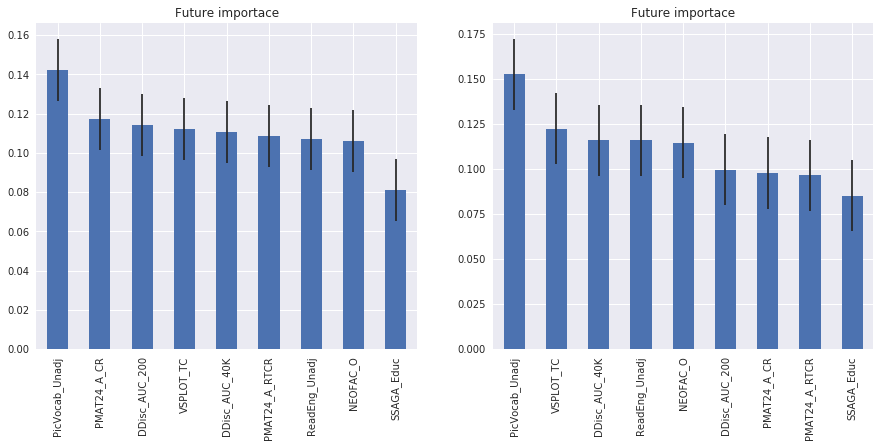

In [219]:
fig, axs = plt.subplots(1,np.shape(high_r2)[0])
from IPython.display import display
for hh in range(np.shape(high_r2)[0]):
    X = all_pheno_pruned[dict_clusters[high_r2[:][hh][1]]]
    x = X.values
    Rsquared_c = np.zeros((np.shape(list_subtype)))
    y = all_clusters_df[high_r2[:][hh][0]]
    y = y.values
    print(high_r2[:][hh])
    Coeff,std, SquaredError,Rsquared,feimp = LinearRegression_apply(x,y, flag_plot=False)
    Rsquared_c[iix] = Rsquared.mean()
    
    
    # Threshold future importance
    feimp_thresh =0 # Percentile of future to be removed
    mean_feimp = np.mean(feimp, axis=0)
    mean_std = np.mean(std, axis=0)
    feature_importances = pd.Series(mean_feimp,index= X.columns)
    feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
    std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
    indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]
    
    # Plot Future importance
    feature_importances_select[indices].plot(kind='bar',yerr=std_select[indices],
                                             figsize=(15,6),title='Future importace',
                                            ax=axs[hh])
    

In [147]:
# Threshold future importance
feimp_thresh =0 # Percentile of future to be removed
mean_feimp = np.mean(feimp, axis=0)
mean_std = np.mean(std, axis=0)
feature_importances = pd.Series(mean_feimp,index= X.columns)
feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]

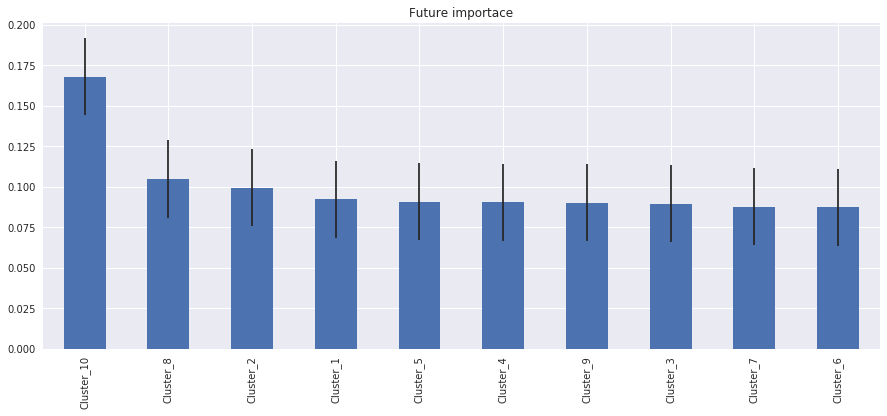

In [148]:
# Plot Future importance
feature_importances_select[indices].plot(kind='bar',yerr=std_select[indices],figsize=(15,6),title='Future importace')

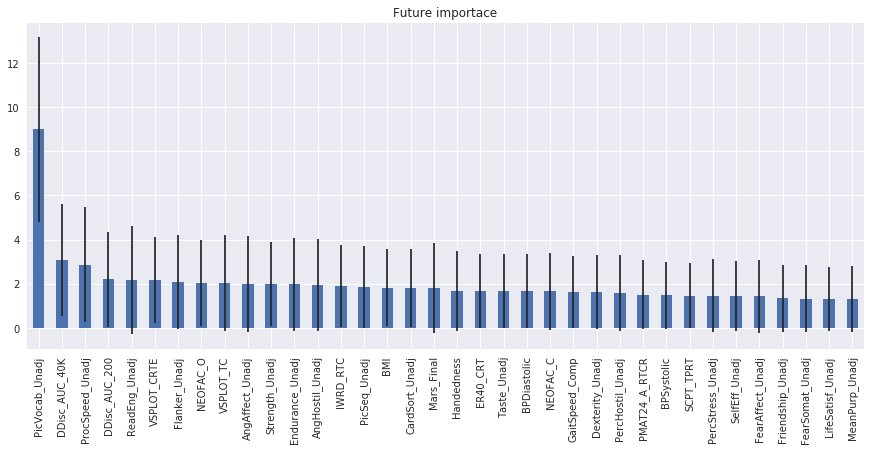

In [125]:
# Plot Future importance
feature_importances_select[indices].plot(kind='bar',yerr=std_select[indices],figsize=(15,6),title='Future importace')